# Scratching Gibbs sampler for Bayesian regression

## Data description


```R
N      <- 100
a_true <- 0.4
mean1  <- 0
mean2  <- 3
sd1    <- 1
sd2    <- 1
Y      <- c(rnorm((1-a_true)*N, mean1, sd1), rnorm(a_true*N, mean2, sd2))
data   <- list(N=N, Y=Y)

write.table(Y, file="points.csv", sep=",", row.names=F, col.names=F)
```

## Model (double normal distribution)

Here we wish to find the posterior distributions of the coefficients mu(the mean) and s(the standard deviation) of a single normal distribution. The model can be written as

$$y_i \sim (1-a)  \mathcal{N}(0, 1) + a \mathcal{N}(\mu_1, 1)$$

$$ z_i \sim Cat(0, 1) $$

$$y_i | z_i \sim  \mathcal{N}(\mu_{z_i}, \sigma_{z_i}^2)$$

$$ \mu_0 = 0$$
$$\mu_1 \sim uniform(-\infty, \infty) $$ 
$$ \sigma_0 = 1$$
$$ \sigma_1 = 1$$
$$ a = \frac {1} {N} \sum_{i=1}^N {z_i}$$

The likelihood for this model may be written as the product over N iid observations

$$L(y_1, \ldots, y_N | \mu_1, z_1, \ldots, z_N) = \prod_{i = 1}^N \mathcal{N}(\mu_{z_i}, \sigma_{z_i}^2)$$


## Pythonic setup

In [102]:
import numpy as np
# np.random.seed(0)

import scipy as sp

import pandas as pd
pd.set_option('display.width', 200)

% matplotlib inline
from seaborn import plt
plt.rcParams['figure.figsize'] = (10, 5)

## Deriving Gibbs sampler

### Update for mu

We are interested in finding

$$ p(\mu_1 | z_1, \ldots, z_N, Y) \propto p(Y |\mu_1, z_1, \ldots, z_N) $$

Note that $p(Y | \mu, a)$ is just the likelihood of the posterior from above. 

Hence $ lp(\mu) $ is 

\begin{eqnarray}
lp(\mu_1) &\propto& \sum \left\{ log\left(\mathcal{N}(\mu_{z_i}, \sigma_{z_i}^2)\right) \mid_{z_i = 1} \right\}\\
&\propto&  -  \frac {1} {2} \sum \left(y_i^2 - 2y_i\mu_1 + \mu_1^2 \mid_{z_i=1}\right) \\
&\propto&  -  \frac {N_1} {2} \mu_1^2 + \left( \sum y_i \mid_{z_i=1} \right)\mu_1 \\
\end{eqnarray}

This expression is quadratic in $\mu$, meaning the conditional sampling density for $\mu$ will also be normal. The coefficient of $ \mu$ is $ \frac{1} {\sigma^2} \sum_{i=1}^N y_i $ while the coefficient of $ \mu^2 $ is $ -  \frac {N} {2\sigma^2}$. This implies the conditional sampling distribution of $ \mu$ is 

$$ \mu_1 | z_1, \ldots, z_N, Y \sim \mathcal{N}\left( \frac{1} {N_1} \sum y_i\mid_{z_i=1}, \frac {1} {N_1} \right), N_1 = \sum^N_{i=1} z_i$$

I turn into a python function:

In [181]:
def sample_mu_1(y, z):
    N1 = np.sum(z)
    mean = np.sum(y * z) / N1
    variance = 1 / N1
    return np.random.normal(mean, np.sqrt(variance))

### Update for z

$$ p(z_i| \mu_1, z_1, \ldots,z_{i-1}, z_{i+1}, \ldots, z_N, Y) \propto p(Y | \mu_1, z_1, \ldots, z_N) = \prod^N_{i=1} \left\{(1-a)  \mathcal{N}(y_i; 0, 1) + a \mathcal{N}(y_i; \mu_1, 1)\right\}$$

I can now code this into python. np.random.gamma uses the shape and scale parameterisation of a Gamma distribution, where the shape $k = \alpha$ but the scale $\theta=1/\beta $, hence we need to invert our expression for $\beta$ before sampling:

In [199]:
norm0 = sp.stats.norm(0, 1)

def sample_z(y, mu_1, z):
    norm1 = sp.stats.norm(mu_1, 1)
    for i in range(len(z)):
        a = np.sum(z)/len(z)
        d0 = (1-a) * norm0.pdf(y[i])
        d1 = a * norm1.pdf(y[i])
        z[i] = 0 if np.random.uniform() * (d0+d1) < d0 else 1

## Writing the Gibbs sampler

Now we ready to write the Gibbs sampler. Apart from the data we need to supply initial parameter estimates.

In [200]:
init = {"mu_1": np.random.uniform(-100, 100), "z": np.random.randint(0, 2, 100)}
print(init)

{'mu_1': -73.40841234803344, 'z': array([1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1])}


In [201]:
def gibbs(y, iters, init):
    mu_1 = init["mu_1"]
    z = init["z"]
    N = len(y)
    
    trace = np.zeros((iters, 2)) ## trace to store values of mu_1, a
    
    for i in range(iters):
        mu_1 = sample_mu_1(y, z)
        sample_z(y, mu_1, z)
        trace[i, :] = np.array((mu_1, np.sum(z)/N))
    
    trace = pd.DataFrame(trace)
    trace.columns = ['mu_1', 'a']
    
    return trace

In [212]:
iters = 10000
y = np.array([float(x) for x in open("points.csv", "r").read().strip().split("\n")])
trace = gibbs(y, iters, init)

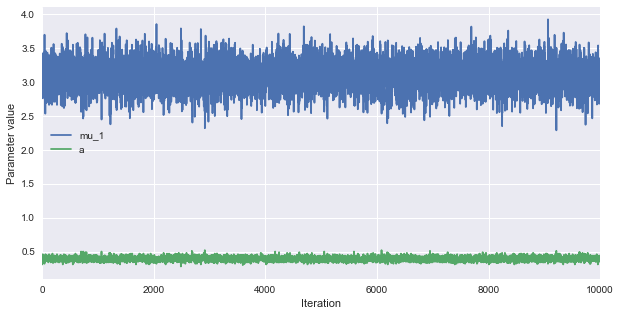

In [213]:
traceplot = trace.plot()
traceplot.set_xlabel("Iteration")
traceplot.set_ylabel("Parameter value")

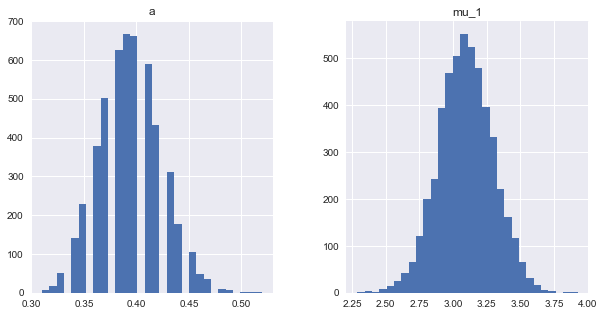

In [214]:
trace_burnt = trace[int(len(trace)/2):]
hist_plot = trace_burnt.hist(bins = 30, layout = (1,2))

I code the WAIC and WBIC functions.

In [215]:
def waic(log_likelihoods):
    training_error = -np.log(np.exp(log_likelihoods).mean(axis=0)).mean()
    functional_variance_div_N = (np.power(log_likelihoods, 2).mean(axis=0) -
                                 np.power(log_likelihoods.mean(axis=0),2)).mean()
    return training_error + functional_variance_div_N

def wbic(log_likelihoods):
    return -log_likelihoods.sum(axis=1).mean()


I can report the descriptive statistics of mu and s, and WAIC/WBIC of current model(single normal distribution).

In [216]:
print(trace_burnt.describe().T)
# print("waic:", waic(log_likelihoods))
# print("wbic:", wbic(log_likelihoods))

       count      mean       std      min       25%       50%       75%       max
mu_1  5000.0  3.095135  0.201434  2.28882  2.960406  3.092896  3.230557  3.926278
a     5000.0  0.393782  0.029200  0.31000  0.370000  0.390000  0.410000  0.520000


## Compare to Rstan

Finally we run the regression and WAIC/WBIC calculation with R and stan. The result and code are above. The result is similar to that of my scratched Gibbs sampling.

In [176]:
from subprocess import check_output

print(check_output(["Rscript", "run.r"]).decode("utf8"))

# results of the single normal distribution model with Rstan
        mean      se_mean         sd      2.5%       25%       50%       75%     97.5%    n_eff     Rhat
mu 3.0930233 0.0011398696 0.19934557 2.7020393 2.9601138 3.0924020 3.2278038 3.4861748 30584.60 1.000080
a  0.3963891 0.0003309912 0.05569274 0.2905625 0.3582446 0.3951649 0.4335651 0.5073475 28311.59 1.000046

                              WAIC     WBIC
single normal dist. model 1.913717 190.3411



In [177]:
for n, i in enumerate(open("run.r", "r"), 1):
    print("{:2d} {}".format(n, i), end="")

 1 options(width=200)
 2 set.seed(1)
 3 
 4 N      <- 100
 5 a_true <- 0.4
 6 mean1  <- 0
 7 mean2  <- 3
 8 sd1    <- 1
 9 sd2    <- 1
10 Y      <- c(rnorm((1-a_true)*N, mean1, sd1), rnorm(a_true*N, mean2, sd2))
11 data   <- list(N=N, Y=Y)
12 
13 write.table(Y, file="points.csv", sep=",", row.names=F, col.names=F)
14 
15 model2 <- "
16 data {
17   int<lower=1> N;
18   vector[N] Y;
19 }
20 
21 parameters {
22   real<lower=0, upper=1> a;
23   real<lower=-50, upper=50> mu;
24 }
25 
26 model {
27   for(n in 1:N){
28     target += log_sum_exp(
29       log(1-a) + normal_lpdf(Y[n] | 0, 1),
30       log(a) + normal_lpdf(Y[n] | mu, 1)
31     );
32   }
33 }
34 
35 generated quantities {
36   vector[N] log_likelihood;
37   int index;
38   real y_pred;
39   for(n in 1:N)
40     log_likelihood[n] = log_sum_exp(
41       log(1-a) + normal_lpdf(Y[n] | 0, 1),
42       log(a) + normal_lpdf(Y[n] | mu, 1)
43     );
44   index = bernoulli_rng(a);
45   y_pred = normal_rng(index == 1 ? mu: 0, 1);
46 }
47 "

## references

- http://kieranrcampbell.github.io/gibbs-sampling-bayesian-linear-regression/
- http://statmodeling.hatenablog.com/entry/calc-waic-wbic